In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from tqdm import tqdm
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from tqdm import tqdm 
import time
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision.models.resnet import ResNet18_Weights
import pickle
import random
from torch.optim import SGD
from torch.optim.lr_scheduler import CosineAnnealingLR
import statistics
import matplotlib.pyplot as plt

/raid/ganesh/namitha/miniconda3/envs/submodlib-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Import

In [2]:
from submodlib import FacilityLocationFunction, GraphCutFunction, DisparityMinFunction, DisparitySumFunction
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [22]:
with open(f"../milo-base/cifar10/dataframe.pkl", "rb") as f:
    df = pickle.load(f)

# groups = df.groupby('Label')
# dataframes = [group for _, group in groups]
# df = dataframes[0]

### Dimensionality Reduction 

In [12]:
n_components = 50
pca = PCA(n_components=n_components)
features_matrix = np.stack(df['Features'].values)
reduced_features = pca.fit_transform(features_matrix)
df['Reduced_Features'] = list(reduced_features)

In [27]:
from sklearn.manifold import TSNE

n = 250

groups = df.groupby('Label')
dataframes = [group for _, group in groups]

stacked_dataframes = pd.concat([df.iloc[:n] for df in dataframes], ignore_index=True)


all_features = np.stack(df["Features"].values)
# selected_rows = all_features[np.random.choice(all_features.shape[0], n, replace=False)]

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(selected_rows)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.586s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.504624
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.456497
[t-SNE] KL divergence after 300 iterations: 2.572982


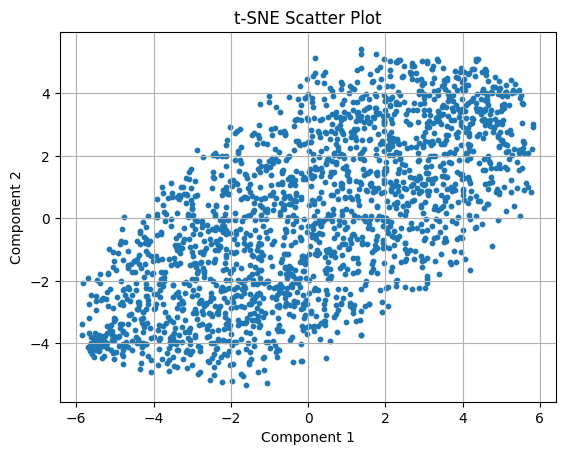

In [29]:
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], s=10)
plt.title('t-SNE Scatter Plot')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True)
plt.show()

In [15]:
import seaborn as sns

data = {}
data['tsne-2d-one'] = tsne_results[:,0]
data['tsne-2d-two'] = tsne_results[:,1]

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=data,
    legend="full",
    alpha=0.3
)

ValueError: Could not interpret value `y` for `hue`. An entry with this name does not appear in `data`.

<Figure size 1600x1000 with 0 Axes>

### Gen Data

In [3]:
bsize = 256
func = "gc"
use_low_dim_features = False
st_data = []
num_set = 0
off = 0

start_time = time.time()

for i in range(0, len(df), bsize):
    chunk = df.iloc[i+off:i+bsize+off]
    try:
        if use_low_dim_features:
            features = np.stack(chunk["Reduced_Features"].values)
        else:
            features = np.stack(chunk["Features"].values)
    except:
        print(i)
    rank = np.linalg.matrix_rank(features)

    if func=="fl":
        obj = FacilityLocationFunction(n=features.shape[0], data=features, separate_rep=False, mode="dense", metric="cosine")
    elif func=="dm":
        obj = DisparityMinFunction(n=features.shape[0], data=features, mode="dense", metric="cosine")
    elif func=="ds":
        obj = DisparitySumFunction(n=features.shape[0], data=features, mode="dense", metric="cosine")
    elif func=="gc":
        obj = GraphCutFunction(n=features.shape[0], data=features, mode="dense", metric="cosine", lambdaVal=0.5)
    else:
        raise Exception("Sorry, no submodlib function defined")

    S = obj.maximize(int(features.shape[0]-1), optimizer='NaiveGreedy', stopIfZeroGain=False, stopIfNegativeGain=False, epsilon=0.1, verbose=False, show_progress=False, costs=None, costSensitiveGreedy=False)
    
    scores = np.zeros(bsize)
    for index, gain in S:
        scores[index] = gain
    
    # scores[np.argmax(scores)] = 1
    st_data.append({"features": features, "gains": scores})
    num_set+=1

time_taken = time.time()-start_time
print(f"time taken to preprocess data set transformer: {time_taken}")

NameError: name 'df' is not defined

time taken to preprocess data set transformer: 71.43237280845642

### gains distibution analysis

254.79803174734116 0.0


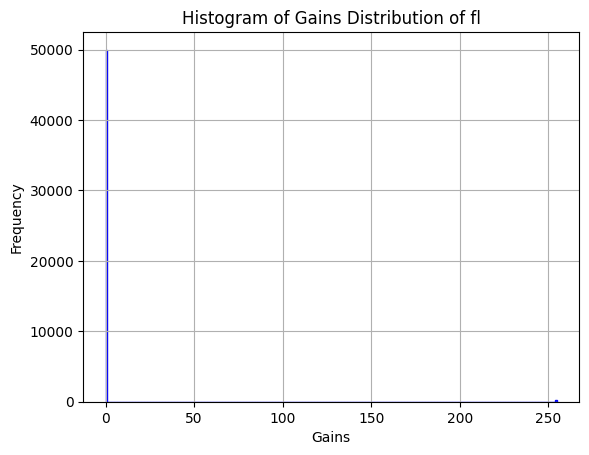

In [6]:
all_gains = []
for data in st_data:
    all_gains.extend(data["gains"])

print(max(all_gains), min(all_gains))

# plt.hist(all_gains, bins=300, range=(-0.0005, 0.0005), edgecolor='blue')
plt.hist(all_gains, bins=300, edgecolor='blue')
plt.title(f'Histogram of Gains Distribution of {func}')
plt.xlabel('Gains')
plt.ylabel('Frequency')
plt.grid(True)

# plt.xticks(ticks=[-0.0005, -0.0003, 0, 0.0003, 0.0005])
# plt.xscale('log')
plt.show()

# plt.hist(all_gains, bins=np.logspace(np.log10(0.001), np.log10(1000), 300), edgecolor='blue')
# plt.title('Histogram of Gains Distribution')
# plt.xlabel('Gains')
# plt.ylabel('Density')
# plt.xscale('log')
# plt.grid(True)

# neural-submod/results/dm_gains_hist

In [25]:
len_ = [len(st_data[i]["features"]) for i in range(170, 196)]
print(len_)

[256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 80]


In [26]:
a=0
for i in st_data:
    if np.max(i["gains"])>a:
        a = np.max(i["gains"])

print(a)

254.79803174734116


In [9]:
with open(f"./data/st_{func}_data.pkl", "wb") as f:
    pickle.dump(st_data, f)

#### Important Sampling Implementation
S0:100, p of S0->S1, 100-p # SGE 
S0:100, prob p, 1-p # WRE gain, scale alreay chosen set elements high, rescale whole distribution and then select.   

## Train Set transformer

In [2]:
from models.set_transformer import *

In [3]:
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda:4" # change the available gpu number
else:
    device = "cpu"

In [25]:
func = "dm"
with open(f"./data/st_{func}_data.pkl", "rb") as f:
    st_data = pickle.load(f)

In [26]:
class STDataset(Dataset):
    def __init__(self, st_data):
        self.st_data = st_data
        
    def __len__(self):
        return len(self.st_data)

    def __getitem__(self, idx):
        return torch.tensor(self.st_data[idx]["features"]).float(), torch.tensor(self.st_data[idx]["gains"]).float()

In [27]:
num_train = int(0.8*len(st_data))
len_ = [len(st_data[i]["features"]) for i in range(num_train, len(st_data))]
print(len_)
print(num_train)

[256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 80]
156


In [28]:
num_train = int(0.8*len(st_data))
st_train_dataset = STDataset(st_data=st_data[:num_train])
st_val_dataset = STDataset(st_data=st_data[num_train:-1])

st_train_dataloader = DataLoader(dataset=st_train_dataset, batch_size=4, num_workers=2, drop_last=True)
st_val_dataloader = DataLoader(dataset=st_val_dataset, batch_size=4, num_workers=2, drop_last=True)

In [29]:
print(len(st_val_dataset))

39


In [30]:
set_transformer = SetTransformer(
    dim_input=1000, 
    num_outputs=256, 
    dim_output=1, 
    num_inds=32, 
    dim_hidden=128, 
    num_heads=4, 
    ln=False
).to(device)

epochs = 10
bsize = 256
frac = 0.3

optimizer = optim.Adam(set_transformer.parameters(), lr = 0.001)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=0.00001)
criterion = nn.MSELoss()

start_time = time.time()
mse_val_loss_list = []
mse_train_loss_list = []
iou_list = []

for epoch in range(epochs):
    step_loss = []
    train_loss = 0
    for sets, gains in st_train_dataloader:
        sets = sets.to(device)
        gains = gains.to(device)

        outputs = set_transformer(sets)
        loss = criterion(outputs, gains.float())
        # loss = criterion(outputs, gains)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        step_loss.append(loss.item())

    # lr_scheduler.step()
    avg_train_loss = train_loss/len(st_train_dataloader)
    #256 set data points
    val_loss = 0
    total_intersection = 0
    total_union = 0

    iou = 0

    with torch.no_grad():
        for sets, gains in st_val_dataloader:
            sets = sets.to(device)
            gains = gains.to(device)

            # Compute top-k gains
            topk_values_, topk_indices_gains = torch.topk(gains.float(), k=int(frac*bsize))
            topk_gains = topk_indices_gains.cpu().numpy().tolist()

            # Get model outputs and compute top-k outputs
            outputs = set_transformer(sets)
            topk_values_outputs, topk_indices_outputs = torch.topk(outputs, k=int(frac*bsize))
            topk_outputs = topk_indices_outputs.cpu().numpy().tolist()

            # Compute intersections and unions for IoU
            for gain_set, output_set in zip(topk_gains, topk_outputs):
                intersection = np.intersect1d(gain_set, output_set)
                union = np.union1d(gain_set, output_set)
                total_intersection += len(intersection)
                total_union += len(union)
                iou += len(intersection)/len(union) if len(union) !=0 else 0
                # if epoch==epochs-1:
                #     print(len(intersection), len(union))

            # Compute validation loss
            loss = criterion(outputs, gains.float())
            val_loss += loss.item()

    # Calculate average IoU and validation loss over all batches
    avg_iou = total_intersection / total_union if total_union != 0 else 0
    avg_val_loss = val_loss / len(st_val_dataloader)

    # avg_iou = iou/len(st_val_dataloader)
    mse_val_loss_list.append(avg_val_loss)
    mse_train_loss_list.append(avg_train_loss)
    iou_list.append(avg_iou)

    if epoch%5==4 or epoch in range(9):
        print(f"Avg Train Loss: {avg_train_loss}, Avg Val Loss: {avg_val_loss}, Avg IoU: {avg_iou}")

time_taken = time.time()-start_time
print(f"time take to train set transformer: {time_taken}")

Avg Train Loss: 0.3786506667160071, Avg Val Loss: 0.012118002710243067, Avg IoU: 0.17702731770273178
Avg Train Loss: 0.00690747598090615, Avg Val Loss: 0.005010478767669863, Avg IoU: 0.17273896270895842
Avg Train Loss: 0.004765196070552637, Avg Val Loss: 0.0045068649471633965, Avg IoU: 0.1793103448275862
Avg Train Loss: 0.004354210654034829, Avg Val Loss: 0.004522469515601794, Avg IoU: 0.17500536826283014
Avg Train Loss: 0.004375054381596737, Avg Val Loss: 0.0041750398878422045, Avg IoU: 0.18160224573526237
Avg Train Loss: 0.0042275412199206846, Avg Val Loss: 0.00442286425580581, Avg IoU: 0.18262373027879836
Avg Train Loss: 0.0042489018553915694, Avg Val Loss: 0.0042982808210783536, Avg IoU: 0.16948065826031203
Avg Train Loss: 0.004221918121075783, Avg Val Loss: 0.004201452816940016, Avg IoU: 0.17123287671232876
Avg Train Loss: 0.004231185437395022, Avg Val Loss: 0.004418942611664534, Avg IoU: 0.18058252427184465
Avg Train Loss: 0.004224802355449169, Avg Val Loss: 0.004439295321289036,

In [31]:
var = 0
for i in iou_list:
    var+=i

print(var/len(iou_list))

0.17673913727124393


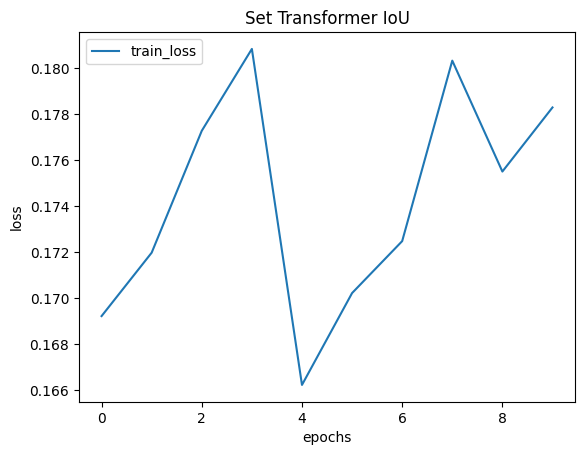

In [37]:
l = len(iou_list)
x = range(l)

# plt.plot(x, mse_val_loss_list[:l], label='val_loss')
# plt.plot(x, mse_train_loss_list[:l], label='train_loss')
plt.plot(x, iou_list[:l], label='train_loss')

# Add labels and title
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Set Transformer IoU')

# plt.xticks(ticks=[i for i in range(epochs)])

# Add legend
plt.legend()

# Show plot
plt.show()

time take to train set transformer 5 epochs: 2.9615519046783447

### Train Loop with Pretrained ST

In [21]:
from models.LeNet_model import LeNet

In [11]:
# Define data transforms
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Load CIFAR10 datasets
train_dataset = datasets.CIFAR10(root="../data", train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [22]:
# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2, drop_last=True)

In [23]:
epochs = 20
bsize = 256
frac = 0.3

# Initialize models
model = LeNet().to(device)

# Define loss function and optimizers
criterion = nn.CrossEntropyLoss()
model_optimizer = optim.Adam(model.parameters())

feature_extracter = torchvision.models.resnet18(weights=None).to(device) 

selection = "hard"
start_time = time.time()

acc_list_st = []

for epoch in tqdm(range(epochs)):  # num_epochs is defined by you
    model.train()
    set_transformer.eval()
    # classification task training
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        image_feautres = feature_extracter(images)
        
        with torch.no_grad():  # We don't update set transformer during the model update phase
            # selection_scores = set_transformer(image_feautres).sigmoid() 
            selection_scores = set_transformer(image_feautres.unsqueeze(0))

        if selection == 'soft':
            weights = selection_scores / selection_scores.sum()  # Normalize scores to use as weights
            outputs = model(images)
            loss = (criterion(outputs, labels) * weights).mean() 
            # Not subset modelling 
        elif selection == 'hard':
            _, topk_indices = torch.topk(selection_scores.squeeze(), k=min(int(frac*bsize), selection_scores.numel()))  # Example: select top 64 for training
            selected_inputs = images[topk_indices]
            selected_labels = labels[topk_indices]
            outputs = model(selected_inputs)
            loss = criterion(outputs, selected_labels)
        
        # Backward pass and update weights
        model_optimizer.zero_grad()
        loss.backward()
        model_optimizer.step()

    # Evaluate on test set
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    acc_list_st.append(accuracy)


time_taken = time.time()-start_time
print(acc_list_st)
print(f"time taken for {epochs} epochs: {time_taken}")

100%|██████████| 20/20 [02:29<00:00,  7.47s/it]

[0.35556891025641024, 0.4188701923076923, 0.4325921474358974, 0.45142227564102566, 0.4699519230769231, 0.4889823717948718, 0.49529246794871795, 0.49168669871794873, 0.5188301282051282, 0.5179286858974359, 0.5302483974358975, 0.5285456730769231, 0.5348557692307693, 0.5311498397435898, 0.5397636217948718, 0.5426682692307693, 0.5361578525641025, 0.5447716346153846, 0.5405649038461539, 0.5296474358974359]
time taken for 20 epochs: 149.41500616073608


time taken for 100 epochs: 651.7725563049316

In [18]:
acc_pst_fl = [0.3486578525641026, 0.3853165064102564, 0.4231770833333333, 0.4517227564102564, 0.4466145833333333, 0.46484375, 0.4635416666666667, 0.4868790064102564, 0.49228766025641024, 0.5089142628205128, 0.5113181089743589, 0.49919871794871795, 0.5065104166666666, 0.5243389423076923, 0.5262419871794872, 0.5308493589743589, 0.5318509615384616, 0.5404647435897436, 0.5438701923076923, 0.5490785256410257, 0.5453725961538461, 0.5628004807692307, 0.5631009615384616, 0.5634014423076923, 0.5710136217948718, 0.5752203525641025, 0.5578926282051282, 0.578125, 0.5731169871794872, 0.5762219551282052, 0.5830328525641025, 0.5849358974358975, 0.5845352564102564, 0.5834334935897436, 0.5897435897435898, 0.5796274038461539, 0.5899439102564102, 0.5998597756410257, 0.5830328525641025, 0.5947516025641025, 0.5966546474358975, 0.5963541666666666, 0.6045673076923077, 0.6030649038461539, 0.5991586538461539, 0.6068709935897436, 0.6096754807692307, 0.6025641025641025, 0.6108774038461539, 0.6097756410256411, 0.6155849358974359, 0.6180889423076923, 0.6039663461538461, 0.6043669871794872, 0.6065705128205128, 0.6172876602564102, 0.6198918269230769, 0.6082732371794872, 0.6230969551282052, 0.6199919871794872, 0.6261017628205128, 0.6193910256410257, 0.6221955128205128, 0.6303084935897436, 0.6334134615384616, 0.6319110576923077, 0.6282051282051282, 0.6301081730769231, 0.633613782051282, 0.6284054487179487, 0.6379206730769231, 0.6351161858974359, 0.6358173076923077, 0.6295072115384616, 0.6346153846153846, 0.6423277243589743, 0.6380208333333334, 0.6345152243589743, 0.6433293269230769, 0.6470352564102564, 0.6296073717948718, 0.6363181089743589, 0.6335136217948718, 0.6524439102564102, 0.6495392628205128, 0.6452323717948718, 0.6380208333333334, 0.641426282051282, 0.6498397435897436, 0.647636217948718, 0.6548477564102564, 0.6488381410256411, 0.6558493589743589, 0.6524439102564102, 0.6442307692307693, 0.6539463141025641, 0.6534455128205128, 0.6506410256410257, 0.6569511217948718, 0.6586538461538461]

In [19]:
acc_pst_dm = [0.375400641025641, 0.4032451923076923, 0.43960336538461536, 0.4599358974358974, 0.4713541666666667, 0.49268830128205127, 0.4985977564102564, 0.5091145833333334, 0.48818108974358976, 0.5204326923076923, 0.5287459935897436, 0.5097155448717948, 0.5297475961538461, 0.5290464743589743, 0.5276442307692307, 0.5440705128205128, 0.5474759615384616, 0.5428685897435898, 0.549979967948718, 0.5519831730769231, 0.5436698717948718, 0.5562900641025641, 0.5588942307692307, 0.5575921474358975, 0.5687099358974359, 0.5519831730769231, 0.5724158653846154, 0.5579927884615384, 0.5733173076923077, 0.5543870192307693, 0.5747195512820513, 0.5797275641025641, 0.5796274038461539, 0.5767227564102564, 0.5783253205128205, 0.5888421474358975, 0.5896434294871795, 0.5784254807692307, 0.5882411858974359, 0.5999599358974359, 0.5953525641025641, 0.5926482371794872, 0.6018629807692307, 0.5934495192307693, 0.5897435897435898, 0.5973557692307693, 0.6036658653846154, 0.6084735576923077, 0.5907451923076923, 0.6034655448717948, 0.6009615384615384, 0.5993589743589743, 0.6092748397435898, 0.6072716346153846, 0.6041666666666666, 0.6003605769230769, 0.6049679487179487, 0.6026642628205128, 0.6035657051282052, 0.6033653846153846, 0.6088741987179487, 0.6079727564102564, 0.606270032051282, 0.6127804487179487, 0.6057692307692307, 0.6170873397435898, 0.6165865384615384, 0.6184895833333334, 0.6209935897435898, 0.6182892628205128, 0.6151842948717948, 0.6180889423076923, 0.6273036858974359, 0.6274038461538461, 0.6227964743589743, 0.6214943910256411, 0.6180889423076923, 0.6283052884615384, 0.6201923076923077, 0.6219951923076923, 0.6263020833333334, 0.6283052884615384, 0.6216947115384616, 0.62109375, 0.6263020833333334, 0.6265024038461539, 0.6244991987179487, 0.6174879807692307, 0.6349158653846154, 0.6319110576923077, 0.6138822115384616, 0.6335136217948718, 0.6378205128205128, 0.6276041666666666, 0.6330128205128205, 0.6358173076923077, 0.6356169871794872, 0.629707532051282, 0.6370192307692307, 0.6400240384615384]

In [20]:
acc_pst_gc = [0.2887620192307692, 0.30618990384615385, 0.33643830128205127, 0.36318108974358976, 0.3922275641025641, 0.39733573717948717, 0.40795272435897434, 0.4124599358974359, 0.4305889423076923, 0.41466346153846156, 0.4228766025641026, 0.42948717948717946, 0.44451121794871795, 0.44931891025641024, 0.46274038461538464, 0.46173878205128205, 0.46764823717948717, 0.4634415064102564, 0.46264022435897434, 0.47606169871794873]

In [33]:
acc_pst_ds = [0.20923477564102563, 0.30388621794871795, 0.29627403846153844, 0.33213141025641024, 0.3825120192307692, 0.3687900641025641, 0.3931290064102564, 0.3828125, 0.4117588141025641, 0.43539663461538464, 0.43830128205128205, 0.43599759615384615, 0.4367988782051282, 0.43529647435897434, 0.444911858974359, 0.46704727564102566, 0.47706330128205127, 0.47676282051282054, 0.4817708333333333, 0.4729567307692308]

### First Epoch Loss

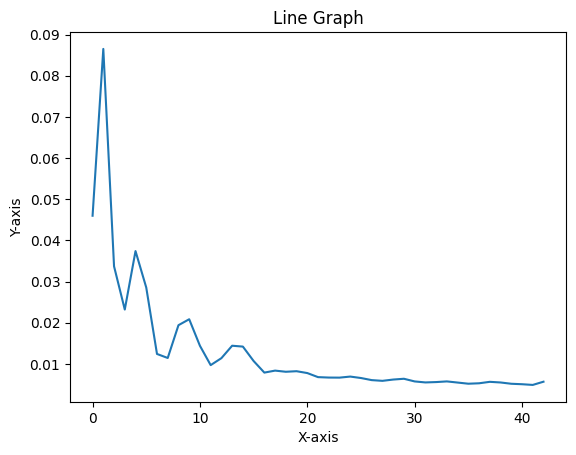

In [18]:
x = range(len(step_loss))

# Plot
plt.plot(x, step_loss)

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Line Graph')

# Show plot
plt.show()

### Pretrained ST Comparison

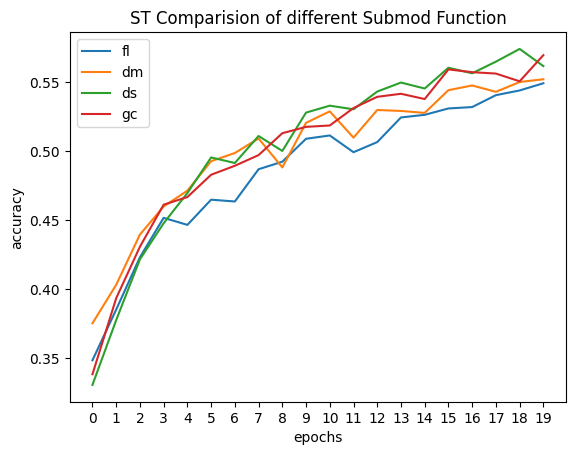

In [45]:
epochs = 20
x = range(epochs)

# Plot both lines
# plt.plot(x, hard_list, label='ST-hard')
plt.plot(x, acc_pst_fl[:epochs], label='fl')
plt.plot(x, acc_pst_dm[:epochs], label='dm')
plt.plot(x, acc_pst_ds[:epochs], label='ds')
plt.plot(x, acc_pst_gc[:epochs], label='gc')

# Add labels and title
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('ST Comparision of different Submod Function')

plt.xticks(ticks=[i for i in range(epochs)])

# Add legend
plt.legend()

# Show plot
plt.show()

### Milo SGE Runs

In [70]:
acc_rand_30_dynamic = [0.3593, 0.4077, 0.4287, 0.4618, 0.4712, 0.4778, 0.4966, 0.5085, 0.5182, 0.5196, 0.5334, 0.5171, 0.5356, 0.5336, 0.5532, 0.5614, 0.5399, 0.5718, 0.5723, 0.5799]
acc_rand_05_dynamic = [0.2127, 0.2697, 0.3003, 0.3247, 0.33, 0.3484, 0.3573, 0.3725, 0.3831, 0.403, 0.4038, 0.4224, 0.4156, 0.4093, 0.4048, 0.4107, 0.4397, 0.4371, 0.4465, 0.4241]
acc_rand_05_static = [0.2581, 0.2946, 0.33, 0.3528, 0.3538, 0.3632, 0.3877, 0.396, 0.4077, 0.4105, 0.4033, 0.4145, 0.4153, 0.4249, 0.4355, 0.4294, 0.4383, 0.4401, 0.4359, 0.4324]
acc_rand_30_static = [0.3692, 0.3968, 0.4419, 0.4729, 0.462, 0.4946, 0.5013, 0.5096, 0.5203, 0.5267, 0.5175, 0.5344, 0.545, 0.5401, 0.5624, 0.5514, 0.5409, 0.5616, 0.5585, 0.5739]

#### DM

In [46]:
acc_milo_dm = [0.3557, 0.4126, 0.4414, 0.4616, 0.4748, 0.4937, 0.5112, 0.5225, 0.5302, 0.5092, 0.5333, 0.5523, 0.5308, 0.5583, 0.5553, 0.5536, 0.5542, 0.5761, 0.5647, 0.5616] 
acc_st_dm = [0.2481971153846154, 0.31971153846153844, 0.32632211538461536, 0.35306490384615385, 0.36889022435897434, 0.40514823717948717, 0.4221754807692308, 0.43078926282051283, 0.43699919871794873, 0.4211738782051282, 0.45232371794871795, 0.4348958333333333, 0.45162259615384615, 0.44511217948717946, 0.4402043269230769, 0.47055288461538464, 0.4483173076923077, 0.4609375, 0.4699519230769231, 0.47986778846153844]

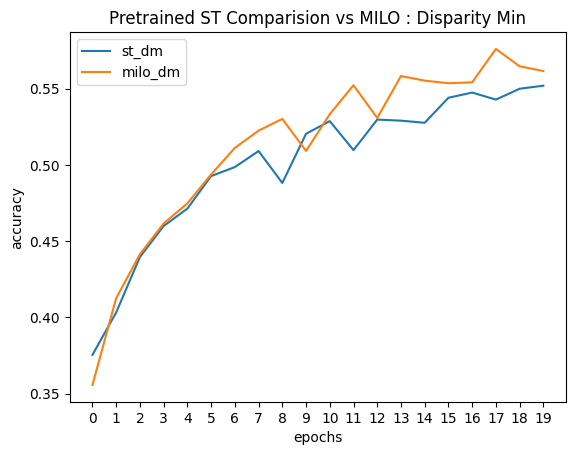

In [47]:
epochs = 20
x = range(epochs)

# Plot both lines
# plt.plot(x, hard_list, label='ST-hard')
plt.plot(x, acc_pst_dm[:epochs], label='st_dm')
plt.plot(x, acc_milo_dm[:epochs], label='milo_dm')
#plt.plot(x, acc_rand[:epochs], label='random')

# Add labels and title
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Pretrained ST Comparision vs MILO : Disparity Min')

plt.xticks(ticks=[i for i in range(epochs)])

# Add legend
plt.legend()

# Show plot
plt.show()

In [28]:
acc_pst_ds_30 = [0.35556891025641024, 0.4188701923076923, 0.4325921474358974, 0.45142227564102566, 0.4699519230769231, 0.4889823717948718, 0.49529246794871795, 0.49168669871794873, 0.5188301282051282, 0.5179286858974359, 0.5302483974358975, 0.5285456730769231, 0.5348557692307693, 0.5311498397435898, 0.5397636217948718, 0.5426682692307693, 0.5361578525641025, 0.5447716346153846, 0.5405649038461539, 0.5296474358974359]
acc_milo_ds_30 = [0.3505, 0.4184, 0.4416, 0.4579, 0.4754, 0.4989, 0.5019, 0.5179, 0.5116, 0.5192, 0.5249, 0.5414, 0.5402, 0.5472, 0.5451, 0.5415, 0.5557, 0.5634, 0.5553, 0.5636]

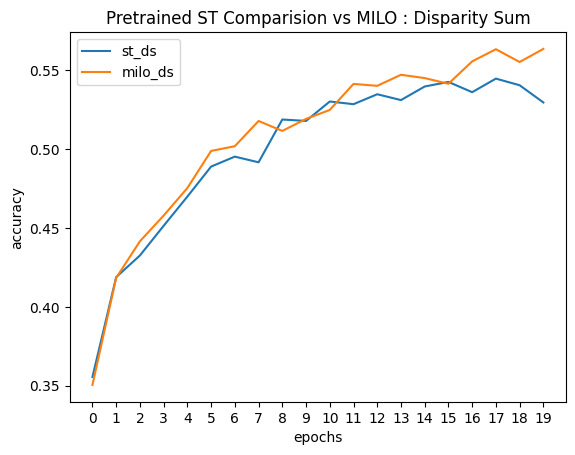

In [29]:
epochs = 20
x = range(epochs)

# Plot both lines
# plt.plot(x, hard_list, label='ST-hard')
plt.plot(x, acc_pst_ds_30[:epochs], label='st_ds')
plt.plot(x, acc_milo_ds_30[:epochs], label='milo_ds')
#plt.plot(x, acc_rand[:epochs], label='random')

# Add labels and title
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Pretrained ST Comparision vs MILO : Disparity Sum')

plt.xticks(ticks=[i for i in range(epochs)])

# Add legend
plt.legend()

# Show plot
plt.show()

#### FL

In [36]:
acc_st_fl_30 = [0.3629807692307692, 0.4165665064102564, 0.43359375, 0.46764823717948717, 0.48066907051282054, 0.48157051282051283, 0.5048076923076923, 0.5091145833333334, 0.5035056089743589, 0.5189302884615384, 0.5154246794871795, 0.5280448717948718, 0.5326522435897436, 0.5440705128205128, 0.5446714743589743, 0.5511818910256411, 0.5640024038461539, 0.5497796474358975, 0.5670072115384616, 0.5566907051282052]
acc_milo_fl_30 = [0.3708, 0.4013, 0.4278, 0.4634, 0.4709, 0.4833, 0.4957, 0.5161, 0.5271, 0.5203, 0.5291, 0.5333, 0.544, 0.5283, 0.5608, 0.5594, 0.565, 0.5681, 0.5784, 0.5423]

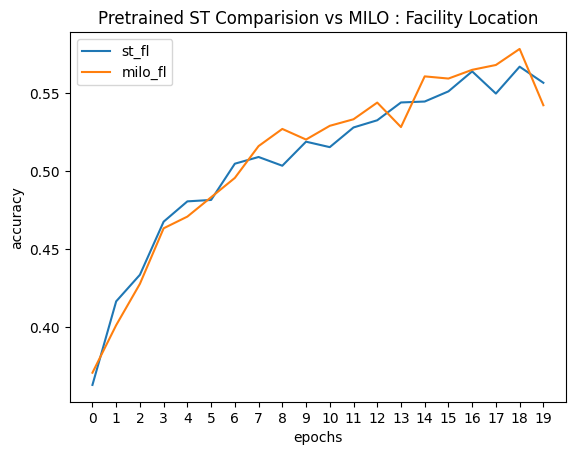

In [49]:
epochs = 20
x = range(epochs)

# Plot both lines
# plt.plot(x, hard_list, label='ST-hard')
plt.plot(x, acc_st_fl_30[:epochs], label='st_fl')
plt.plot(x, acc_milo_fl_30[:epochs], label='milo_fl')

# Add labels and title
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Pretrained ST Comparision vs MILO : Facility Location')

plt.xticks(ticks=[i for i in range(epochs)])

# Add legend
plt.legend()

# Show plot
plt.show()

#### GC

In [25]:
acc_pst_gc_30 = [0.3483573717948718, 0.4069511217948718, 0.45032051282051283, 0.4684495192307692, 0.48487580128205127, 0.48828125, 0.5063100961538461, 0.5116185897435898, 0.5201322115384616, 0.5275440705128205, 0.5326522435897436, 0.5319511217948718, 0.5394631410256411, 0.5454727564102564, 0.5452724358974359, 0.5516826923076923, 0.5511818910256411, 0.565604967948718, 0.5623998397435898, 0.5682091346153846]
acc_milo_gc_05 = [0.2485, 0.284, 0.3275, 0.3421, 0.3642, 0.3676, 0.388, 0.3804, 0.3861, 0.3878, 0.3941, 0.3979, 0.4209, 0.392, 0.4188, 0.4311, 0.4291, 0.4264, 0.4361, 0.4338]
acc_milo_gc_30 = [0.3721, 0.4172, 0.4413, 0.4507, 0.4696, 0.4889, 0.4986, 0.5061, 0.5204, 0.5227, 0.5332, 0.5414, 0.5441, 0.5467, 0.5471, 0.5476, 0.5512, 0.5506, 0.5621, 0.5673]

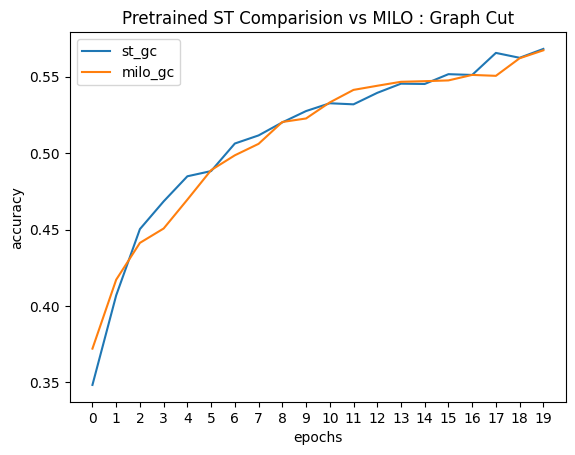

In [26]:
epochs = 20
x = range(epochs)

# Plot both lines
# plt.plot(x, hard_list, label='ST-hard')
plt.plot(x, acc_pst_gc_30[:epochs], label='st_gc')
plt.plot(x, acc_milo_gc_30[:epochs], label='milo_gc')

# Add labels and title
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Pretrained ST Comparision vs MILO : Graph Cut')

plt.xticks(ticks=[i for i in range(epochs)])

# Add legend
plt.legend()

# Show plot
plt.show()